In [ ]:
import numpy as np 
import pandas as pd
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import json
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import re
import gc
import seaborn as sns

import tensorflow as tf
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, SpatialDropout1D, Dense, Dropout, Input, concatenate, Conv1D, Activation, Flatten

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sample_submission = pd.read_csv("/content/drive/MyDrive/sample_submission.csv")
sample_submission.head(20)

,example_id,PredictionString
0,-1011141123527297803_long,NaN
1,-1011141123527297803_short,NaN
2,-1028916936938579349_long,NaN
3,-1028916936938579349_short,NaN
4,-1055197305756217938_long,NaN
5,-1055197305756217938_short,NaN
6,-1074129516932871805_long,NaN
7,-1074129516932871805_short,NaN
8,-1114334749483663139_long,NaN
9,-1114334749483663139_short,NaN


In [ ]:
train_path = '/content/drive/MyDrive/simplified-nq-train.jsonl'
test_path = '/content/drive/MyDrive/simplified-nq-test.jsonl'

In [ ]:
chunksize=2000

In [ ]:
def read_data(path, sample = True, chunksize = chunksize):
    if sample == True:
        df = []
        with open(path, 'r') as reader:
            for i in range(chunksize):
                df.append(json.loads(reader.readline()))
        df = pd.DataFrame(df)
        print('Sample data have {} rows and {} columns'.format(df.shape[0], df.shape[1]))
    else:
        df = pd.read_json(path, orient = 'records', lines = True)
        print('Sample data have {} rows and {} columns'.format(df.shape[0], df.shape[1]))
        gc.collect()
    return df

train = read_data(train_path, sample = True)
test = read_data(test_path, sample = False)
train.head()

Sample data have 2000 rows and 6 columns
Sample data have 346 rows and 4 columns


,document_text,long_answer_candidates,question_text,annotations,document_url,example_id
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,5289242154789678439
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...,"[{'start_token': 32, 'top_level': True, 'end_t...",what happened to the lost settlement of roanoke,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ro...,5489863933082811018


In [ ]:
df = read_data(train_path, sample = True)
print(df['question_text'][1])
print(df['annotations'][1])

Sample data have 2000 rows and 6 columns
how i.met your mother who is the mother
[{'yes_no_answer': 'NONE', 'long_answer': {'start_token': 212, 'candidate_index': 15, 'end_token': 310}, 'short_answers': [{'start_token': 213, 'end_token': 215}], 'annotation_id': 12034874153783787365}]


Text(0.5, 1.0, 'Distribution of text word count of 2000 documents')

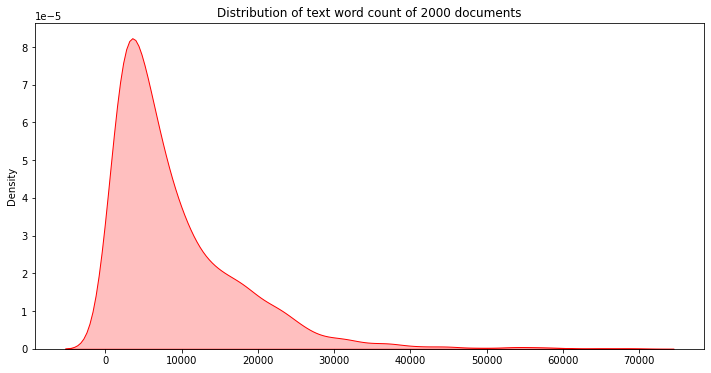

In [ ]:
doc_text_words = df['document_text'].apply(lambda x: len(x.split(' ')))
plt.figure(figsize=(12,6))
sns.kdeplot(doc_text_words.values,shade=True, color="r").set_title('Distribution of text word count of ' + str(chunksize) + ' documents')

In [ ]:
df.long_answer_candidates[0][:5]

[{'start_token': 14, 'top_level': True, 'end_token': 170},
 {'start_token': 15, 'top_level': False, 'end_token': 169},
 {'start_token': 52, 'top_level': False, 'end_token': 103},
 {'start_token': 53, 'top_level': False, 'end_token': 102},
 {'start_token': 103, 'top_level': False, 'end_token': 156}]

In [ ]:
df.annotations[1][:100]

[{'yes_no_answer': 'NONE',
  'long_answer': {'start_token': 212, 'candidate_index': 15, 'end_token': 310},
  'short_answers': [{'start_token': 213, 'end_token': 215}],
  'annotation_id': 12034874153783787365}]

In [ ]:
def preprocess_data():
    df = read_data(train_path, sample = True)
    df['yes_no'] = df.annotations.apply(lambda x: x[0]['yes_no_answer'])
    df['long'] = df.annotations.apply(lambda x: [x[0]['long_answer']['start_token'], x[0]['long_answer']['end_token']])
    df['short'] = df.annotations.apply(lambda x: x[0]['short_answers'])
    return df
df = preprocess_data()
df

Sample data have 2000 rows and 6 columns


,document_text,long_answer_candidates,question_text,annotations,document_url,example_id,yes_no,long,short
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,NONE,"[1952, 2019]","[{'start_token': 1960, 'end_token': 1969}]"
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242,NONE,"[212, 310]","[{'start_token': 213, 'end_token': 215}]"
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852,NONE,"[319, 438]",[]
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,5289242154789678439,NONE,"[509, 576]","[{'start_token': 512, 'end_token': 514}]"
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...,"[{'start_token': 32, 'top_level': True, 'end_t...",what happened to the lost settlement of roanoke,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ro...,5489863933082811018,NONE,"[-1, -1]",[]
...,...,...,...,...,...,...,...,...,...
1995,Grace and Frankie - Wikipedia <H1> Grace and F...,"[{'start_token': 10, 'top_level': True, 'end_t...",how long is each grace and frankie episode,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Gr...,-7716384782891686197,NONE,"[10, 399]","[{'start_token': 300, 'end_token': 304}]"
1996,Cellular respiration - wikipedia <H1> Cellular...,"[{'start_token': 10, 'top_level': True, 'end_t...",after complete oxidation of a glucose molecule...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ce...,8933277615800380148,NONE,"[780, 883]","[{'start_token': 796, 'end_token': 799}]"
1997,Some Like It Hot ( song ) - wikipedia <H1> Som...,"[{'start_token': 18, 'top_level': True, 'end_t...",who sings the song some like it hot,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=So...,-6909007989280228395,NONE,"[-1, -1]",[]
1998,Princes in the Tower - wikipedia <H1> Princes ...,"[{'start_token': 44, 'top_level': True, 'end_t...",who killed the twins in the tower of london,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Pr...,1501574334625895729,NONE,"[-1, -1]",[]


In [ ]:
def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)

In [ ]:
df['hash']=df['question_text'].apply(lambda x: find_hash(x))

In [ ]:
df['hash'].value_counts()

    2000
Name: hash, dtype: int64

In [ ]:
df.loc[df['hash'].str.strip() == '', 'hash'] = df['document_text']

In [ ]:
def find_punct(text):
    line = re.findall(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', text)
    string="".join(line)
    return list(string)

In [ ]:
df['punctuation']=df['question_text'].apply(lambda x : find_punct(x))
df.loc[df['hash'].str.strip() == '', 'hash'] = df['question_text']

In [ ]:
num_train_ques = 2000
num_val_ques = 2050
sample_rate = 15

In [ ]:
epochs = 40
batch_size = 64
class_weights = {0: 0.5, 1: 5.}

In [ ]:
def get_question_and_document(line):
    question = line['question_text']
    text = line['document_text'].split(' ')
    annotations = line['annotations'][0]    
    return question, text, annotations
                
def get_long_candidate(i, annotations, candidate):
    # check if this candidate is the correct long answer
    if i == annotations['long_answer']['candidate_index']:
        label = True
    else:
        label = False

    # get place where long answer starts and ends in the document text
    long_start = candidate['start_token']
    long_end = candidate['end_token']    
    return label, long_start, long_end

def form_data_row(question, label, text, long_start, long_end):
    row = {
        'question': question,
        'long_answer': ' '.join(text[long_start:long_end]),
        'is_long_answer': label,
    }    
    return row

In [ ]:
def load_data(file_path, questions_start, questions_end):
    rows = []
    
    with open(file_path) as file:
        for i in tqdm(range(questions_start, questions_end)):
            line = file.readline()
            line = json.loads(line)
            question, text, annotations = get_question_and_document(line)

            for i, candidate in enumerate(line['long_answer_candidates']):
                label, long_start, long_end = get_long_candidate(i, annotations, candidate)

                if label == True or (i % sample_rate == 0):
                    rows.append(
                        form_data_row(question, label, text, long_start, long_end)
                    )        
    return pd.DataFrame(rows)

In [ ]:
train_df = load_data(train_path, 0, num_train_ques)
test_df = load_data(train_path, num_train_ques, num_val_ques)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
def remove_stopwords(sentence):
    words = sentence.split()
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

#removing html ta
def remove_html(sentence):
    html = re.compile(r'<.*?>` `` ')
    return html.sub(r'', sentence)

#returns the pre-processed dataframe for long answers and questions
def preprocessed_df(df):
    df['long_answer'] = df['long_answer'].apply(lambda x : remove_stopwords(x))
    df['long_answer'] = df['long_answer'].apply(lambda x : remove_html(x))

    df['question'] = df['question'].apply(lambda x : remove_stopwords(x))
    df['question'] = df['question'].apply(lambda x : remove_html(x))
    
    return df

In [ ]:
def ngrams_top(corpus,ngram_range,n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english',ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list=words_freq[:n]
    df=pd.DataFrame(total_list,columns=['text','count'])
    return df

In [ ]:
ngrams_top(df['question_text'],(3,3),n=10)

,text,count
0,big bang theory,6
1,orange new black,5
2,world cup semi,4
3,cup semi final,4
4,located world map,4
5,president united states,3
6,won world cup,3
7,gold does glitter,2
8,hitchhiker guide galaxy,2
9,fa cup final,2


In [ ]:
train_df = preprocessed_df(train_df)
test_df = preprocessed_df(test_df)
train_df.head(5)

,question,long_answer,is_long_answer
0,common use opt-in e-mail marketing,<Table> <Tr> <Td> </Td> <Td> ( hide ) This art...,False
1,common use opt-in e-mail marketing,<Tr> <Td> <Ul> <Li> Pay - per - click </Li> <L...,False
2,common use opt-in e-mail marketing,<P> Email marketing evolved rapidly alongside ...,False
3,common use opt-in e-mail marketing,<Li> Advertisers reach substantial numbers ema...,False
4,common use opt-in e-mail marketing,<P> A common example permission marketing news...,True


In [ ]:
filters = '!"''#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
lower_case = True
max_len = 500

In [ ]:
def define_tokenizer(series):
    sentences = pd.concat(series)    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=lower_case,filters=filters  )
    tokenizer.fit_on_texts(sentences)
    return tokenizer
 
def encode(sentences, tokenizer):
    encoded_sentences = tokenizer.texts_to_sequences(sentences)
    encoded_sentences = tf.keras.preprocessing.sequence.pad_sequences(encoded_sentences,
                                                                      maxlen=max_len, padding='post')
    return encoded_sentences

In [ ]:
tokenizer = define_tokenizer([train_df.long_answer,train_df.question,
                              test_df.long_answer,test_df.question])

In [ ]:
word_index = tokenizer.word_index
print('Number of Unique Tokens: %d' % len(word_index))

Number of Unique Tokens: 67075


In [ ]:
train_long_answers = encode(train_df['long_answer'].values, tokenizer)
train_questions = encode(train_df['question'].values, tokenizer)

test_long_answers = encode(test_df['long_answer'].values, tokenizer)
test_questions = encode(test_df['question'].values, tokenizer)

In [ ]:
train_labels = train_df.is_long_answer.astype(int).values
test_labels = test_df.is_long_answer.astype(int).values

In [ ]:
embed_size = 200
embedding_dict = {}

with open('/content/drive/MyDrive/glove.6B.' + str(embed_size) + 'd.txt','r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors        
f.close()

In [ ]:
num_words = len(word_index) + 1

embedding_matrix = np.zeros((num_words, embed_size))
print("num_words:", num_words)
print("embedding_matrix:", embedding_matrix)

num_words: 67076
embedding_matrix: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
for word, i in word_index.items():
    if i > num_words:
        continue
    
    emb_vec = embedding_dict.get(word)
    
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

In [ ]:
embedding_layer = tf.keras.layers.Embedding(
    len(word_index) + 1,
    embed_size,
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable = False
)

In [ ]:
question_input = Input(shape=(None,))
question_x = embedding_layer(question_input)
question_x = SpatialDropout1D(0.2)(question_x)
question_x = Bidirectional(LSTM(100, return_sequences=True))(question_x)
question_x = GlobalMaxPooling1D()(question_x) 

# answer encoding-encodes the answer
answer_input = Input(shape=(None,))
answer_x = embedding_layer(answer_input)
answer_x = SpatialDropout1D(0.2)(answer_x)
answer_x = Bidirectional(LSTM(150, return_sequences=True))(answer_x)
answer_x = GlobalMaxPooling1D()(answer_x) 

# classification
combined_x = concatenate([question_x, answer_x])
combined_x = Dense(300, activation='relu')(combined_x)
combined_x = Dropout(0.5)(combined_x)
combined_x = Dense(300, activation='relu')(combined_x)
combined_x = Dropout(0.5)(combined_x)
model_output = Dense(1, activation='sigmoid')(combined_x) 

# defining model by combining above three parts
model = tf.keras.models.Model(inputs=[answer_input, question_input], outputs=model_output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 200)    13415200    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, None, 200)   0           ['embedding[0][0]']          

In [ ]:
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['BinaryAccuracy', 'Recall', 'Precision'])

In [ ]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),]

In [ ]:
epochs = 40
batch_size = 128
class_weights = {0: 0.5, 1: 5.}

In [ ]:
history = model.fit(
    x = [train_long_answers, train_questions], 
    y = train_labels,
    validation_data = (
        [test_long_answers, test_questions], test_labels),
    epochs = epochs,
    callbacks = callbacks,
    class_weight = class_weights,
    batch_size = batch_size,
    shuffle = True
)

Epoch 1/40
157/157 [==============================] - 40s 182ms/step - loss: 0.3660 - binary_accuracy: 0.8030 - recall: 0.6204 - precision: 0.1539 - val_loss: 0.3585 - val_binary_accuracy: 0.7661 - val_recall: 1.0000 - val_precision: 0.2097 - lr: 0.0010
Epoch 2/40
157/157 [==============================] - 28s 176ms/step - loss: 0.2883 - binary_accuracy: 0.8113 - recall: 0.7900 - precision: 0.1876 - val_loss: 0.2899 - val_binary_accuracy: 0.8282 - val_recall: 0.8462 - val_precision: 0.2444 - lr: 0.0010
Epoch 3/40
157/157 [==============================] - 29s 182ms/step - loss: 0.2687 - binary_accuracy: 0.8296 - recall: 0.8064 - precision: 0.2072 - val_loss: 0.2090 - val_binary_accuracy: 0.8711 - val_recall: 0.8462 - val_precision: 0.3056 - lr: 0.0010
Epoch 4/40
157/157 [==============================] - 28s 180ms/step - loss: 0.2517 - binary_accuracy: 0.8399 - recall: 0.8295 - precision: 0.2219 - val_loss: 0.3521 - val_binary_accuracy: 0.7828 - val_recall: 1.0000 - val_precision: 0.22

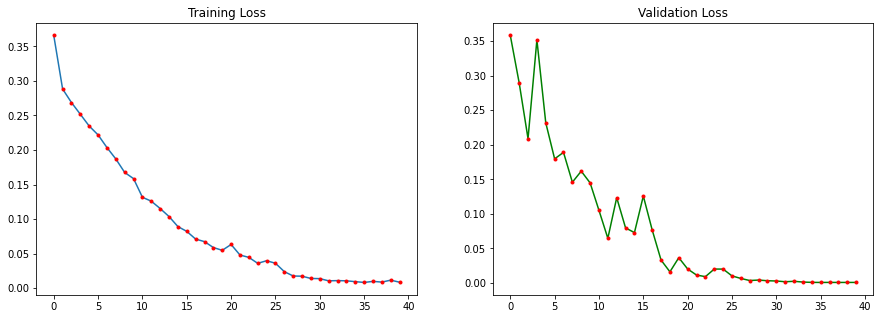

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['loss'],marker = '.',mec = 'r', mfc = 'r')

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['val_loss'],marker = '.',mec = 'r', mfc = 'r',color="green")

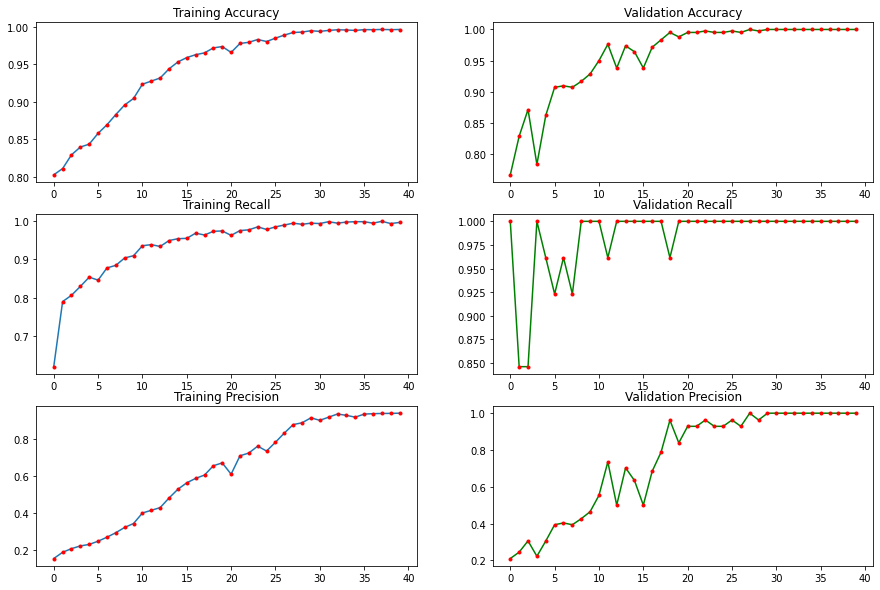

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

ax[0,0].set_title('Training Accuracy')
ax[0,0].plot(history.history['binary_accuracy'],marker = '.',mec = 'r', mfc = 'r')

ax[0,1].set_title('Validation Accuracy')
ax[0,1].plot(history.history['val_binary_accuracy'],marker = '.',mec = 'r', mfc = 'r',color="green")

ax[1,0].set_title('Training Recall')
ax[1,0].plot(history.history['recall'],marker = '.',mec = 'r', mfc = 'r')

ax[1,1].set_title('Validation Recall')
ax[1,1].plot(history.history['val_recall'],marker = '.',mec = 'r', mfc = 'r',color="green")

ax[2,0].set_title('Training Precision')
ax[2,0].plot(history.history['precision'],marker = '.',mec = 'r', mfc = 'r')

ax[2,1].set_title('Validation Precision')
ax[2,1].plot(history.history['val_precision'],marker = '.',mec = 'r', mfc = 'r',color="green")

In [ ]:
#Evaluate checking recall

recall = history.history['recall'][-1]
precision = history.history['precision'][-1]

print('Train F1 score: {0:.4f}'.format(
    2 * (precision * recall) / (precision + recall)
))

recall = history.history['val_recall'][-1]
precision = history.history['val_precision'][-1]

print('Validation F1 score: {0:.4f}'.format(2 * (precision * recall) / (precision + recall)))

Train F1 score: 0.9659
Validation F1 score: 1.0000


In [ ]:
predictions = model.predict([np.expand_dims(test_labels, axis=0), np.expand_dims(test_labels, axis=0)])

1/1 [==============================] - 1s 1s/step


In [ ]:
def test_question(question, positive, negative):
    sentences = [question, positive, negative]
    
    for i in range(3):
        sentences[i] = remove_stopwords(sentences[i])
        sentences[i] = remove_html(sentences[i])
    
    sentences = encode(sentences, tokenizer)
    
    predictions = model.predict([np.expand_dims(sentences[1], axis=0), np.expand_dims(sentences[0], axis=0)])

    print('Positive: {0:.2f}'.format(predictions[0][0]))

    predictions = model.predict(
        [np.expand_dims(sentences[2], axis=0), np.expand_dims(sentences[0], axis=0)])

    print('Negative: {0:.2f}'.format(predictions[0][0]))
    return predictions

In [ ]:
question = 'who invented a portable handset '

positive='<P> Martin Cooper invented a portable handset in 1973, when he was a project manager at Motorola. It was almost three decades after the idea of cellular communications was introduced by Bell Laboratories. </P>'
negative = '<P> Email marketing has evolved rapidly alongside the technological growth of the 21st century . Prior to this growth , when emails were novelties to the majority of customers , email marketing was not as effective . In 1978 , Gary Thuerk of Digital Equipment Corporation ( DEC ) sent out the first mass email to approximately 400 potential clients via the Advanced Research Projects Agency Network ( ARPANET ) . This email resulted in $13 million worth of sales in DEC products , and highlighted the potential of marketing through mass emails . However , as email marketing developed as an effective means of direct communication , users began blocking out content from emails with filters and blocking programs . In order to effectively communicate a message through email , marketers had to develop a way of pushing content through to the end user , without being cut out by automatic filters and spam removing software . This resulted in the birth of triggered marketing emails , which are sent to specific users based on their tracked online browsing patterns . </P>'

In [ ]:
if positive>negative:
  print('Positive')
else:
  print('Negative')

Positive


In [ ]:
def get_short_answer(annotations, long_start, long_end):
    if len(annotations['short_answers']) > 0:
        short_start = annotations['short_answers'][0]['start_token']
        short_end = annotations['short_answers'][0]['end_token']        
        short_start = short_start - long_start
        short_end = short_end - long_start        
        return short_start, short_end
    else:
        return 0, 0
    
def form_short_data_row(question, text, long_start, long_end, short_start, short_end):
    long_answer = ' '.join(text[long_start:long_end])
    short_answer = ' '.join(long_answer.split(' ')[short_start:short_end])
    row = {
        'question': question,
        'long_answer': long_answer,
        'short_answer': short_answer,
        'short_start': short_start,
        'short_end': short_end
    }    
    return row

In [ ]:
def load_short_data(file_path, questions_start, questions_end):
    rows = []    
    with open(file_path) as file:

        for i in tqdm(range(questions_start, questions_end)):
            line = file.readline()
            line = json.loads(line)
            question, text, annotations = get_question_and_document(line)

            for i, candidate in enumerate(line['long_answer_candidates']):
                label, long_start, long_end = get_long_candidate(i, annotations, candidate)

                if label == True:
                    short_start, short_end = get_short_answer(annotations, long_start, long_end)
                    
                    rows.append(
                        form_short_data_row(question, text, long_start, long_end, short_start, short_end)
                    )
        
    return pd.DataFrame(rows)

In [ ]:
train_short_df = load_short_data(train_path, 0, num_train_ques)
test_short_df = load_short_data(train_path, num_train_ques, num_val_ques)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
train_long_answers = encode(train_short_df['long_answer'].values, tokenizer)
train_questions = encode(train_short_df['question'].values, tokenizer)

test_long_answers = encode(test_short_df['long_answer'].values, tokenizer)
test_questions = encode(test_short_df['question'].values, tokenizer)

In [ ]:
def form_short_labels(df, sentence_length):
    start_labels = np.zeros((len(df), sentence_length))
    end_labels = np.zeros((len(df), sentence_length))

    #get the token indexes from short_start and short_end columns and assign it to new arrays. encoding with 1
    for i in range(len(df)):
        start = df.loc[i].short_start
        end = df.loc[i].short_end

        if start < 500 and end < 500:
            start_labels[i, start] = 1
            end_labels[i, end] = 1
        else:
            continue
    
    return start_labels, end_labels

train_start_labels, train_end_labels = form_short_labels(train_short_df, max_len)
test_start_labels, test_end_labels = form_short_labels(test_short_df, max_len)

In [ ]:
short_epochs = 75
short_batch_size = 64
embed_size_short=200

In [ ]:
embedding_dict = {}

with open('/content/drive/MyDrive/glove.6B.200' + 'd.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
        
f.close()

# write to matrix
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, embed_size_short))

for word, i in tokenizer.word_index.items():
    if i > num_words:
        continue
    
    emb_vec = embedding_dict.get(word)
    
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

embedding_layer2 = tf.keras.layers.Embedding(
    len(tokenizer.word_index) + 1,
    embed_size_short,
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable = False
)

In [ ]:
question_input = Input(shape=(None,))
question_x = embedding_layer2(question_input)
question_x = SpatialDropout1D(0.2)(question_x)
question_x = Bidirectional(LSTM(200, return_sequences=True))(question_x)
question_x = Bidirectional(LSTM(100, return_sequences=True))(question_x)

# encoding answer input
answer_input = Input(shape=(None,))
answer_x = embedding_layer2(answer_input)
answer_x = SpatialDropout1D(0.2)(answer_x)
answer_x = Bidirectional(LSTM(250, return_sequences=True))(answer_x)
answer_x = Bidirectional(LSTM(150, return_sequences=True))(answer_x)

# merge the encodings
combined_x = concatenate([question_x, answer_x])

# predict start index of the short answer
start_x = Dropout(0.1)(combined_x) 
start_x = Conv1D(1,1)(start_x)
start_x = Flatten()(start_x)
start_x = Activation('softmax', name='start_token')(start_x)

end_x = Dropout(0.1)(combined_x) 
end_x = Conv1D(1,1)(end_x)
end_x = Flatten()(end_x)
end_x = Activation('softmax', name='end_token')(end_x)

# merge the parts into one model
short_model = tf.keras.models.Model(inputs=[answer_input, question_input], outputs=[start_x, end_x])

In [ ]:
short_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['categorical_accuracy', 'Recall', 'Precision'])

In [ ]:
short_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 200)    13415200    ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 spatial_dropout1d_2 (SpatialDr  (None, None, 200)   0           ['embedding_1[0][0]']      

In [ ]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=4, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),]

In [ ]:
history = short_model.fit(
    x = [train_long_answers, train_questions], 
    y = [train_start_labels, train_end_labels],epochs = short_epochs, callbacks = callbacks,
    validation_data = ([test_long_answers, test_questions], [test_start_labels, test_end_labels]),
    batch_size = short_batch_size,  shuffle = True)

Epoch 1/75
17/17 [==============================] - 24s 516ms/step - loss: 9.0286 - start_token_loss: 4.4088 - end_token_loss: 4.6198 - start_token_categorical_accuracy: 0.1618 - start_token_recall: 0.0000e+00 - start_token_precision: 0.0000e+00 - end_token_categorical_accuracy: 0.1262 - end_token_recall_1: 0.0000e+00 - end_token_precision_1: 0.0000e+00 - val_loss: 7.7965 - val_start_token_loss: 3.7749 - val_end_token_loss: 4.0215 - val_start_token_categorical_accuracy: 0.3462 - val_start_token_recall: 0.0000e+00 - val_start_token_precision: 0.0000e+00 - val_end_token_categorical_accuracy: 0.3462 - val_end_token_recall_1: 0.0000e+00 - val_end_token_precision_1: 0.0000e+00 - lr: 0.0010
Epoch 2/75
17/17 [==============================] - 6s 322ms/step - loss: 7.8462 - start_token_loss: 3.8157 - end_token_loss: 4.0305 - start_token_categorical_accuracy: 0.3025 - start_token_recall: 0.0089 - start_token_precision: 0.2045 - end_token_categorical_accuracy: 0.3025 - end_token_recall_1: 9.8619

In [ ]:
print('Epoch: {0}'.format(len(history.history['loss'])))
print('Loss: {0}'.format(history.history['loss'][-1]))

Epoch: 64
Loss: 0.5180085301399231


In [ ]:
print('Accuracies based on positions for training are')

accuracy = history.history['start_token_categorical_accuracy'][-1]
recall = history.history['start_token_recall'][-1]
precision = history.history['start_token_precision'][-1]

print('--------------------------------------------------')
print('Start position accuracy: {0}'.format(accuracy))
print('Start position recall: {0}'.format(recall))
print('Start position precision: {0}'.format(precision))
print('Start position F1 score: {0:.4f}'.format(2 * (precision * recall) / (precision + recall)))

print('--------------------------------------------------')

accuracy = history.history['end_token_categorical_accuracy'][-1]
recall = history.history['end_token_recall_1'][-1]
precision = history.history['end_token_precision_1'][-1]

print('End position accuracy: {0}'.format(accuracy))
print('End position recall: {0}'.format(recall))
print('End position precision: {0}'.format(precision))
print('End position F1 score: {0:.4f}'.format(2 * (precision * recall) / (precision + recall)))

Accuracies based on positions for training are
--------------------------------------------------
Start position accuracy: 0.9123314023017883
Start position recall: 0.9142012000083923
Start position precision: 0.9325955510139465
Start position F1 score: 0.9233
--------------------------------------------------
End position accuracy: 0.9152215719223022
End position recall: 0.9151873588562012
End position precision: 0.9307923913002014
End position F1 score: 0.9229


In [ ]:
print('Accuracies based on letters for training are')
print('--------------------------------------------------')

accuracy = history.history['val_start_token_categorical_accuracy'][-1]
recall = history.history['val_start_token_recall'][-1]
precision = history.history['val_start_token_precision'][-1]

print('Start position accuracy: {0}'.format(accuracy))
print('Start position recall: {0}'.format(recall))
print('Start position precision: {0}'.format(precision))
print('Start position F1 score: {0:.4f}'.format( 2 * (precision * recall) / (precision + recall)))

print('--------------------------------------------------')

accuracy = history.history['val_end_token_categorical_accuracy'][-1]
recall = history.history['val_end_token_recall_1'][-1]
precision = history.history['val_end_token_precision_1'][-1]

print('End position accuracy: {0}'.format(accuracy))
print('End position recall: {0}'.format(recall))
print('End position precision: {0}'.format(precision))
print('End position F1 score: {0:.4f}'.format(2 * (precision * recall) / (precision + recall)))

Accuracies based on letters for training are
--------------------------------------------------
Start position accuracy: 0.9615384340286255
Start position recall: 0.9230769276618958
Start position precision: 1.0
Start position F1 score: 0.9600
--------------------------------------------------
End position accuracy: 0.9230769276618958
End position recall: 0.9230769276618958
End position precision: 0.9599999785423279
End position F1 score: 0.9412


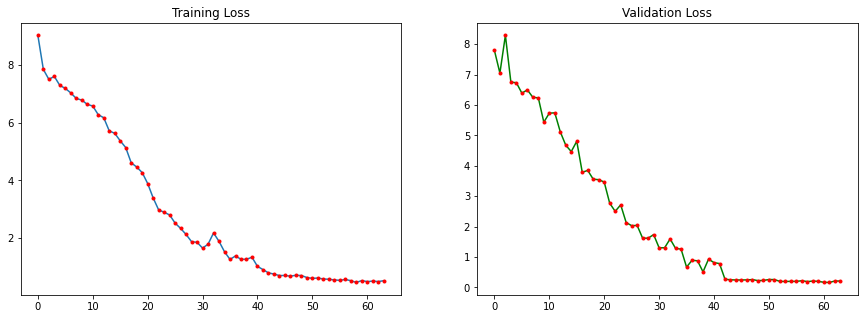

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['loss'],marker = '.',mec = 'r', mfc = 'r')

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['val_loss'],marker = '.',mec = 'r', mfc = 'r',color="green")

In [ ]:
def test_short_answer(question, long_answer):
    sentences = [long_answer, question]
    
    sentences = encode(sentences, tokenizer)
    
    predictions = short_model.predict(
        [np.expand_dims(sentences[0], axis=0), np.expand_dims(sentences[1], axis=0)])
    
    predictions = np.array(predictions)
    
    prediction_start = np.argmax(predictions[0,0])
    prediction_end = np.argmax(predictions[1,0])
    prediction_string = ' '.join(long_answer.split(' ')[prediction_start:prediction_end])

    return prediction_start, prediction_end, prediction_string

In [ ]:
%%bash

 pip install --upgrade pip
 pip install git+https://github.com/deepset-ai/haystack.git#egg=farm-haystack[colab,faiss]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepset-ai/haystack.git to /tmp/pip-install-6jmevm82/farm-haystack_bc6c51d6308a4ed5944b672b6bcc3bae
  Resolved https://github.com/deepset-ai/haystack.git to commit 0c71849e4adb5dbf7debbbb425f8cb760ea0e01e
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━

  Running command git clone --filter=blob:none --quiet https://github.com/deepset-ai/haystack.git /tmp/pip-install-6jmevm82/farm-haystack_bc6c51d6308a4ed5944b672b6bcc3bae


In [ ]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.INFO)

In [ ]:
import pandas as pd

from haystack.utils import fetch_archive_from_http


# Download sample
# doc_dir = "data/tutorial7/"
# s3_url = "https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/small_generator_dataset.csv.zip"
# fetch_archive_from_http(url=s3_url, output_dir=doc_dir)

# Create dataframe with columns "title" and "text"
df = pd.read_csv(f"/content/drive/MyDrive/small_generator_dataset.csv", sep=",")
# Minimal cleaning
df.fillna(value="", inplace=True)

print(df.head())

               title  \
0  "Albert Einstein"   
1  "Albert Einstein"   
2  "Albert Einstein"   
3  "Albert Einstein"   
4     "Alfred Nobel"   

                                                                              text  
0  to Einstein in 1922. Footnotes Citations Albert Einstein Albert Einstein (; ...  
1  Albert Einstein Albert Einstein (; ; 14 March 1879 – 18 April 1955) was a Ge...  
2  observations were published in the international media, making Einstein worl...  
3  model for depictions of mad scientists and absent-minded professors; his exp...  
4  was adopted as the standard technology for mining in the "Age of Engineering...  


In [ ]:
from haystack import Document


# Use data to initialize Document objects
titles = list(df["title"].values)
texts = list(df["text"].values)
documents = []
for title, text in zip(titles, texts):
    documents.append(Document(content=text, meta={"name": title or ""}))

In [ ]:
from haystack.document_stores import FAISSDocumentStore
from haystack.nodes import RAGenerator, DensePassageRetriever


# Initialize FAISS document store.
# Set `return_embedding` to `True`, so generator doesn't have to perform re-embedding
document_store = FAISSDocumentStore(faiss_index_factory_str="Flat", return_embedding=True)

# Initialize DPR Retriever to encode documents, encode question and query documents
retriever = DensePassageRetriever(
    document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    use_gpu=True,
    embed_title=True,
)

# Initialize RAG Generator
generator = RAGenerator(
    model_name_or_path="facebook/rag-token-nq",
    use_gpu=True,
    top_k=1,
    max_length=200,
    min_length=2,
    embed_title=True,
    num_beams=2,
)

INFO:haystack.telemetry:Haystack sends anonymous usage data to understand the actual usage and steer dev efforts towards features that are most meaningful to users. You can opt-out at anytime by calling disable_telemetry() or by manually setting the environment variable HAYSTACK_TELEMETRY_ENABLED as described for different operating systems on the documentation page. More information at https://docs.haystack.deepset.ai/docs/telemetry
INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1


INFO:haystack.modeling.model.language_model:Auto-detected model language: english


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.


INFO:haystack.modeling.model.language_model:Auto-detected model language: english
INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1


/usr/local/lib/python3.8/dist-packages/transformers/models/bart/configuration_bart.py:179: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizerFast'.


Some weights of the model checkpoint at facebook/rag-token-nq were not used when initializing RagTokenForGeneration: ['rag.question_encoder.question_encoder.bert_model.pooler.dense.bias', 'rag.question_encoder.question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing RagTokenForGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RagTokenForGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RagTokenForGeneration were not initialized from the model checkpoint at facebook/rag-token-nq and are newly initialized: ['rag.generator.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictio

In [ ]:
# Delete existing documents in documents store
document_store.delete_documents()

# Write documents to document store
document_store.write_documents(documents)

# Add documents embeddings to index
document_store.update_embeddings(retriever=retriever)

Here are our questions:

In [ ]:
QUESTIONS = [
    # "who got the first nobel prize in physics",
    # "who most impozrtant and influential filmmakers in the history of cinema",
    # "ashes series is played between australia and which country",
    # "united kingdom made how many centuries in ashes tests",
    # "when is the next deadpool movie being released",
    # "which mode is used for short wave broadcast service",
    # "who is the owner of reading football club",
    # "when is the next scandal episode coming out",
    # "when is the last time the philadelphia won the superbowl",
    # "what is the most current adobe flash player version",
    # "how many episodes are there in dragon ball z",
    # "what is the first step in the evolution of the eye",
    # "where is gall bladder situated in human body",
    # "what is the main mineral in lithium batteries",
    # "who is the president of usa right now",
    # "where do the greasers live in the outsiders",
    # "panda is a national animal of which country",
    # "what is the name of manchester united stadium",
    "wheel of dhARMA HAS 12 SPOKES WHICH REPRESeNT",
    # "who is lionel messi",
    # "కంటి వైద్యుడిని ఏమంటారు ?",
]

In [ ]:
# Or alternatively use the Pipeline class
from haystack.pipelines import GenerativeQAPipeline, DocumentSearchPipeline
from haystack.utils import print_answers, print_documents
import json
pipe = GenerativeQAPipeline(generator=generator, retriever=retriever)
doc_pipe = DocumentSearchPipeline(retriever=retriever)

for question in QUESTIONS:#
    res = doc_pipe.run(query=question, params={"Retriever": {"top_k": 4}}) 
    print((res["documents"][0].content)+"\n")
   
    
    
    res = pipe.run(query=question, params={"Generator": {"top_k": 1}, "Retriever": {"top_k": 4}})
    print_answers(res, details="minimum")

In [ ]:
from haystack.pipelines import GenerativeQAPipeline, DocumentSearchPipeline
from haystack.utils import print_answers, print_documents
import json
# pipe = GenerativeQAPipeline(generator=generator, retriever=retriever)
doc_pipe = DocumentSearchPipeline(retriever=retriever)

for question in QUESTIONS:#
    res = doc_pipe.run(query=question, params={"Retriever": {"top_k": 1}}) 
    print((res["documents"][0].content)+"\n")
    # print_documents(res)

In [ ]:
# question = 'which is the most common example of opt-in e-mail marketing'
question = 'who is the ceo of apple?'
long_answer ="<P>steve jobs is the ceo of apple</P>"
# long_answer = "<P> A common example of permission marketing is a newsletter sent to an advertising firm 's customers . Such newsletters inform customers of upcoming events or promotions , or new products . In this type of advertising , a company that wants to send a newsletter to their customers may ask them at the point of purchase if they would like to receive the newsletter . </P>"

In [ ]:
start, end, short_answer = test_short_answer(question, long_answer)

print('Start token: ' + str(start))
print('End token: ' + str(end))
print('Answer: ' + short_answer)

In [ ]:

pip install translators --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import translators as ts
ts.google
ts._google.language_map

Using state  server backend.


In [ ]:
tel_question = 'ఆప్ట్-ఇన్ ఇ-మెయిల్ మార్కెటింగ్ యొక్క అత్యంత సాధారణ ఉదాహరణ ఏది?'
# tel_question="ఆల్బర్ట్ ఐన్‌స్టీన్"
eng_question=ts.google(tel_question, from_language='te', to_language='en')
print(eng_question)

Which is the most common example of opt-in e-mail marketing?


In [ ]:
start, end, short_answer = test_short_answer(eng_question, long_answer)

print('Start token: ' + str(start))
print('End token: ' + str(end))
print('Answer: ' + short_answer)

NameError: ignored

In [ ]:
tel_answer=ts.google(short_answer, from_language='en', to_language='te')
print(tel_answer)

NameError: ignored

In [ ]:
eng_question = ' to Einstein in 1922. Footnotes Citations Albert Einstein Albert Einstein (; ; 14 March 1879 â 18 April 1955) was a German-born theoretical physicist who developed the theory of relativity, one of the two pillars of modern physics (alongside quantum mechanics). His work is also known for its influence on the philosophy of science. He is best known to the general public for his massâenergy equivalence formula , which has been dubbed the worlds most famous equation. He received the 1921 Nobel Prize in Physics for his services to theoretical physics, and especially for his discovery of the law of'
# tel_question="ఆల్బర్ట్ ఐన్‌స్టీన్"
tel_question=ts.google(eng_question, from_language='en', to_language='te')
print(tel_question)

1922 లో ఐన్‌స్టీన్‌కు. ఫుట్‌నోట్స్ అనులేఖనాలు ఆల్బర్ట్ ఐన్‌స్టీన్ ఆల్బర్ట్ ఐన్‌స్టీన్ (; ). అతని పని సైన్స్ తత్వశాస్త్రంపై ప్రభావం చూపడానికి కూడా ప్రసిద్ది చెందింది. ప్రపంచంలోని అత్యంత ప్రసిద్ధ సమీకరణం అని పిలువబడే తన మాస్ ఎనర్జీ ఈక్వివలెన్స్ ఫార్ములా కోసం అతను సాధారణ ప్రజలకు బాగా ప్రసిద్ది చెందాడు. అతను సైద్ధాంతిక భౌతిక శాస్త్రానికి తన సేవలకు మరియు ముఖ్యంగా చట్టాన్ని కనుగొన్నందుకు భౌతిక శాస్త్రంలో 1921 నోబెల్ బహుమతిని అందుకున్నాడు
